In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.metrics import Precision, Recall
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Define the paths for the training and testing datasets
train_dir = '/content/drive/MyDrive/cotton/TRAIN'
test_dir = '/content/drive/MyDrive/cotton/TEST'

# Define the image size and batch size
img_size = (224, 224)
batch_size = 32
ep=29

# Create an image data generator for the training set
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

# Create an image data generator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)


Found 1196 images belonging to 4 classes.
Found 256 images belonging to 4 classes.


#Vgg16

In [5]:
# Load the pre-trained VGG16 model
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=img_size + (3,))

for layer in base_model_vgg16.layers:
  layer.trainable = False

# Add a global spatial average pooling layer
x_vgg16 = base_model_vgg16.output
x_vgg16 = tf.keras.layers.GlobalAveragePooling2D()(x_vgg16)

# Add a fully-connected layer
x_vgg16 = tf.keras.layers.Dense(1024, activation='relu')(x_vgg16)

# Add a logistic layer with the number of classes
predictions_vgg16 = tf.keras.layers.Dense(4, activation='softmax')(x_vgg16)

# Create the VGG16 model
model = tf.keras.models.Model(inputs=base_model_vgg16.input, outputs=predictions_vgg16)

model.summary()

# Compile the VGG16 model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,3

 Total params: 15,244,100 (58.15 MB)

 Trainable params: 529,412 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
# Train the model
r=model.fit(train_generator,validation_data=test_generator, epochs=ep,  steps_per_epoch=len(train_generator),
  validation_steps=len(test_generator))

Epoch 1/29


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 649s 15s/step - accuracy: 0.5466 - loss: 1.0929 - precision: 0.8208 - recall: 0.2432 - val_accuracy: 0.8203 - val_loss: 0.6052 - val_precision: 0.8708 - val_recall: 0.7109
Epoch 2/29
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/29


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 270ms/step - accuracy: 0.8167 - loss: 0.5448 - precision: 0.9012 - recall: 0.7389 - val_accuracy: 0.8789 - val_loss: 0.3727 - val_precision: 0.9513 - val_recall: 0.8398
Epoch 4/29
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/29
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 258ms/step - accuracy: 0.9011 - loss: 0.3450 - precision: 0.9445 - recall: 0.8468 - val_accuracy: 0.9062 - val_loss: 0.3194 - val_precision: 0.9274 - val_recall: 0.8984
Epoch 6/29
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/29
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 260ms/step - accuracy: 0.9327 - loss: 0.2738 - precision: 0.9528 - recall: 0.8824 - val_accuracy: 0.9180 - val_loss: 0.2540 - val_precision: 0.9496 - val_recall: 0.8828
Epoch 8/29
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - prec

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step


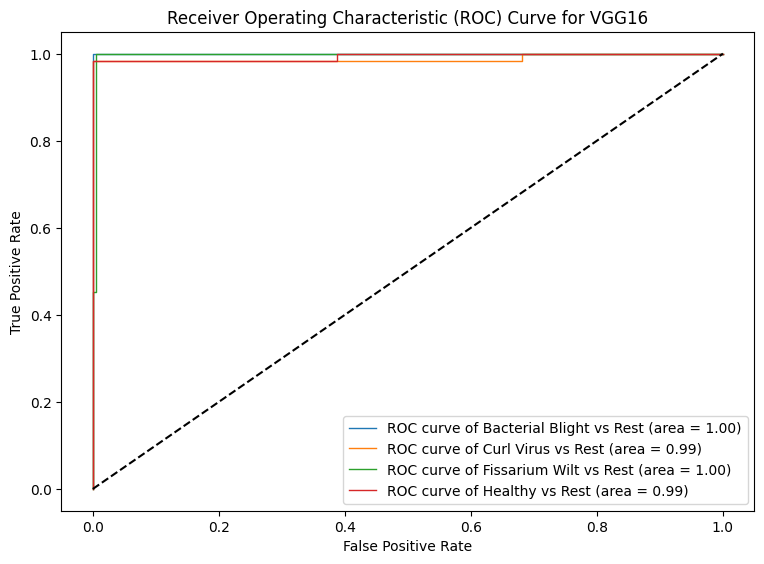

In [7]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming you have defined y_pred, y_test_bin, fpr, tpr, and roc_auc as in your code
y_pred = model.predict(test_generator)
y_test = test_generator.classes
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define disease names
disease_names = ['Bacterial Blight', 'Curl Virus', 'Fissarium Wilt', 'Healthy']

# Plot the ROC curves with disease names
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

line_widths = [1,1,1,1]  # Define line widths for each class

for i in range(4):
    plt.plot(fpr[i], tpr[i], linewidth=line_widths[i],
             label='ROC curve of {0} vs Rest (area = {1:0.2f})'.format(disease_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.05])  # Set x-axis limits with a slight padding
plt.ylim([-0.05, 1.05])  # Set y-axis limits with a slight padding
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for VGG16')
plt.legend(loc="lower right")

# Adjust the plot dimensions and add padding to the inner part
plt.tight_layout(pad=2.0)  # Adjust the padding value as needed

plt.show()


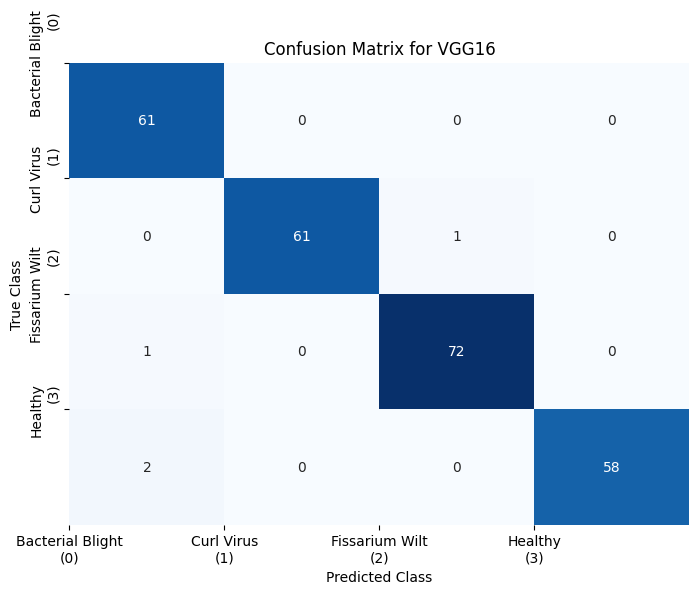

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have defined y_pred, y_test_bin, disease_names as in your code snippet
# y_pred = ...
# y_test_bin = ...
# disease_names = ...

# Get the predicted classes from probabilities
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8 , 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

# Set axis labels and title
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix for VGG16')

# Set tick labels
tick_labels = [f'{disease_names[i]}\n({i})' for i in range(len(disease_names))]
plt.xticks(np.arange(len(disease_names)), tick_labels)
plt.yticks(np.arange(len(disease_names)), tick_labels)

# Show the plot
plt.show()


In [9]:
def plot_learningCurve(history, epoch):
# Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('VGG16 Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
#Plot training & validation Loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('VGG16 Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'val'], loc='upper left')
  plt.show()

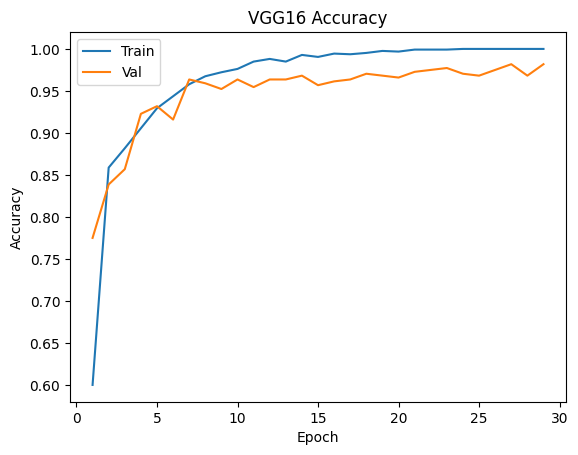

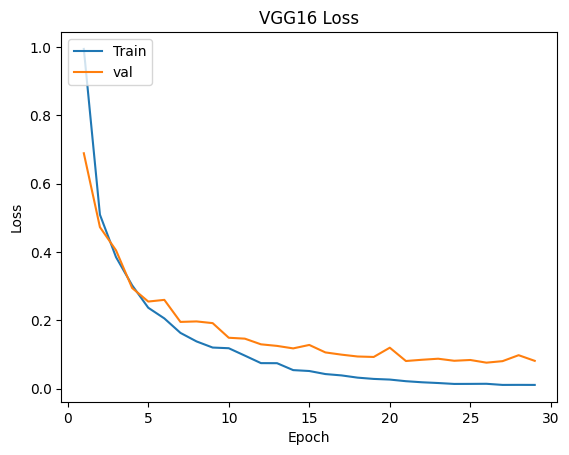

In [ ]:
plot_learningCurve(r, ep)

#Saving Models

In [10]:
model.save('/content/drive/MyDrive/Models/vgg16_bs32_ep29.h5')

